In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case6'
model_name = 'case6_modflow'
model_ws = './models_folder/' + data_folder

Lx = 0.2
Ly = 1.0

nrow = 1
ncol = 180
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

top = 1.0
botm = 0.0

laytyp = 1

hk = 1.0

nper = 2
perlen = [0.05944444, 0.1488889]
nstp = [250, 600]
steady = [True, True]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc, top=top, botm=botm,
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=1, ipakcb=53, ss=0.1)

wel_data = {0: [[0, 0, 0, 2.839]],}
wel = flopy.modflow.ModflowWel(model, ipakcb=66, stress_period_data=wel_data, unitnumber=78)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data)#, compact=True)

pcg = flopy.modflow.ModflowPcg(model=model)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  0.9999999403953552


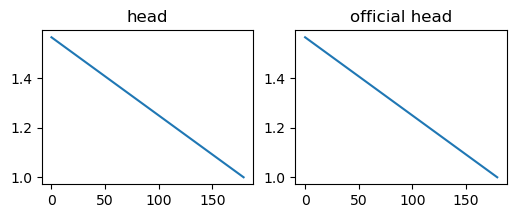

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex06_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(head[-1, 0, 0])
plt.title("head")
plt.subplot(122)
plt.plot(head_official[-1, 0, 0])
plt.title("official head")

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=0,
    ph_ph=0,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/case6\\pht3d_ph.dat'

In [5]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

## Initiate RCH data...
# rch_spec={}
# for key in spec.keys():
#    rch_spec[key]={}

for i in range(1):
    # rch and wel
    for key in spec.keys():
        # rch_spec[key][i]=spec[key][0,:,:]
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.00001420
    wel_spec['ca'] = 0.0
    wel_spec['cl'] = 0.0
    wel_spec['na'] = 0.005
    wel_spec['tenside'] = 0.005
    
    wel_spec['ph'] = 7
    wel_spec['pe'] = 4

    wel_spec['calcite'] = 0.0
    wel_spec['calciumtenside'] = 0.0

    wel_spec['cax2'] = 0.0
    wel_spec['nax'] = 0.0

    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

for i in range(1,2):
    # rch and wel
    for key in spec.keys():
        # rch_spec[key][i]=spec[key][0,:,:]
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.00001420
    wel_spec['ca'] = 0.0
    wel_spec['cl'] = 0.005
    wel_spec['na'] = 0.005
    wel_spec['tenside'] = 0.0
    
    wel_spec['ph'] = 7
    wel_spec['pe'] = 4

    wel_spec['calcite'] = 0.0
    wel_spec['calciumtenside'] = 0.0

    wel_spec['cax2'] = 0.0
    wel_spec['nax'] = 0.0

    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0,
  0,
  0,
  0.0,
  2,
  1.42e-05,
  0.0,
  0.0,
  0.005,
  0.005,
  7,
  4,
  0.0,
  0.0,
  0.0,
  0.0],
 1: [0,
  0,
  0,
  0.0,
  2,
  1.42e-05,
  0.0,
  0.005,
  0.005,
  0.0,
  7,
  4,
  0.0,
  0.0,
  0.0,
  0.0]}

In [6]:
icbund = np.abs(ibound)

## Initiate model object
mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms.exe',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 0.424
## Define FloPy packages
save_times = np.array([0, 2.083E-03, 4.167E-03, 6.250E-03, 8.333E-03, 1.042E-02, .0125, 1.458E-02, 1.667E-02, .01875, 2.083E-02, 2.292E-02, .025, 
                       2.708E-02, 2.917E-02, .03125, 3.333E-02, 3.542E-02, 3.750E-02, 3.958E-02, 4.167E-02, 4.375E-02, 4.583E-02, 4.792E-02, 5.000E-02, 
                       5.208E-02, 5.417E-02, 5.625E-02, 5.833E-02, 6.042E-02, 6.250E-02, 6.458E-02, 6.667E-02, 6.875E-02, 7.083E-02, 7.292E-02, 7.500E-02, 
                       7.708E-02, 7.917E-02, .08125, 8.333E-02, 8.542E-02, .0875, 8.958E-02, 9.167E-02, 9.375E-02, 9.583E-02, 9.792E-02, 1.000E-01, .1020833, 
                       .1041666, .10625, .1083333, .1104166, .1125, .1145833, .1166666, .11875, .1208333, .1229166, .125, .1270833, .1291666, .13125, 
                       .1333333, .1354166, .1375, .1395833, .1416666, .14375, .1458333, .1479166, .1499999, .1520833, .1541666, .1562499, .1583333, .1604166, 
                       .1624999, .1645833, .1666666, .1687499, .1708333, .1729166, .1749999, .1770833, .1791666, .1812499, .1833332, .1854166, .1874999, .1895832, 
                       .1916666, .1937499, .1958332, .1979166, .1999999, .2020832, .2041666, .2062499, .2083332])
exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp,\
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=1, mxstrn=50000, tsmult=1, timprs=save_times, \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75, mxpart=5000, nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.000576, trpt=0.1, trpv=0.1, multiDiff=True, dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=2, cclose=1.e-10)
# exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000, {pht3d_fsp.create.crch_ssm})') # call SSM package in this way to invoke PHT3D-FSP variables
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
# kwargs={'sp12':2e-4}
# rct = flopy.mt3d.Mt3dRct(mt,rhob=1800.0,ireact=0,isothm=1,sp1=0,igetsc=0,**kwargs)
mt.write_input()

DSP: setting dmcoef for component 2 to zero, kwarg name dmcoef2
DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4
DSP: setting dmcoef for component 5 to zero, kwarg name dmcoef5


In [7]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [8]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO   0.23778E-03

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:  1.2446E-04 Total Elapsed Time:  1.24456E-04
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4269      [K,I,J]    1    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6175E-02  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1127E-03  [K,I,J]    1    1  179
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1954E-05  [K,I,J]    1    1    1
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3764E-07  [K,I,J]    1    1  179
 Outer Iter.  1  Inner Iter.  6:  Max

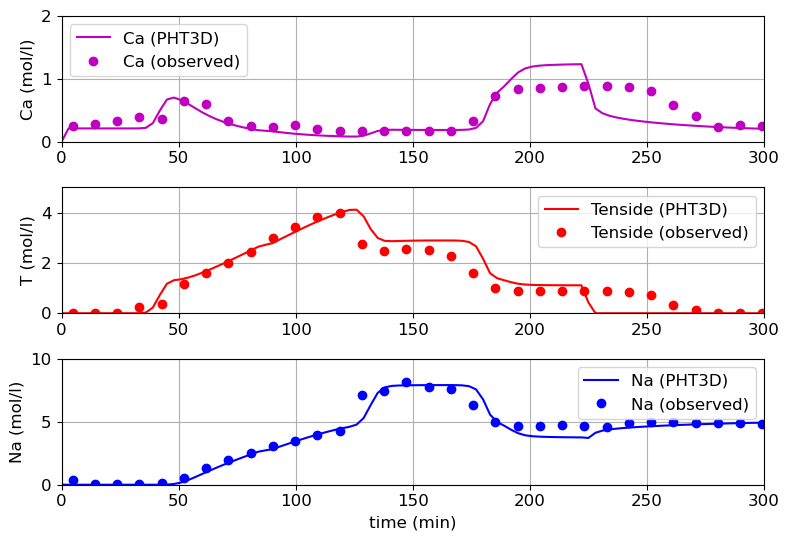

In [9]:
Ca = np.loadtxt(f'{model_ws}/PHT3D002.ACN') * 1000
Na = np.loadtxt(f'{model_ws}/PHT3D004.ACN') * 1000
T  = np.loadtxt(f'{model_ws}/PHT3D005.ACN') * 1000

T_dist = np.array([0, 0, 0, 0.3, 0.43, 1.4, 1.92, 2.39, 2.93, 3.6, 4.10, 4.58, 4.76, 3.3, 2.97, 3.08, 3.0, 2.72, 1.90, 1.20, 1.06, 1.06, 1.06, 1.06, 1.06, 1.0, 0.86, 0.41, 0.16, 0, 0, 0, ])
T_meas = T_dist * 0.007 / 8.38 # cm * mol/l / cm
T_meas = T_meas * 1000 # mmol/l

Na_dist = np.array([0.42, 0.1, 0.08, 0.1, 0.15, 0.63, 1.61, 2.31, 3.0, 3.7, 4.12, 4.72, 5.12, 8.58, 8.95, 9.8, 9.3, 9.12, 7.58, 5.95, 5.56, 5.6, 5.7, 5.55, 5.48, 5.9, 5.98, 5.98, 5.9, 5.92, 5.91, 5.8])
Na_meas = Na_dist * 0.007 / 8.38
Na_meas = Na_meas * 1000 # mmol/l

Ca_dist = np.array([0.3, 0.33, 0.4, 0.48, 0.43, 0.78, 0.72, 0.4, 0.3, 0.28, 0.32, 0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.87, 1.01, 1.03, 1.05, 1.06, 1.06, 1.05, 0.97, 0.7, 0.49, 0.28, 0.31, 0.3])
Ca_meas = Ca_dist * 0.007 / 8.38
Ca_meas = Ca_meas * 1000 # mmol/l

times_meas = np.arange(4.7498, 4.7498 + 9.4995 * (31 + 1), 9.4995)

times = np.array([0, 2.083E-03, 4.167E-03, 6.250E-03, 8.333E-03, 1.042E-02, .0125, 1.458E-02, 1.667E-02, .01875, 2.083E-02, 2.292E-02, .025, 2.708E-02, 2.917E-02, .03125, 3.333E-02, 3.542E-02, 3.750E-02, 3.958E-02, 4.167E-02, 4.375E-02, 4.583E-02, 4.792E-02, 5.000E-02, 5.208E-02, 5.417E-02, 5.625E-02, 5.833E-02, 6.042E-02, 6.250E-02, 6.458E-02, 6.667E-02, 6.875E-02, 7.083E-02, 7.292E-02, 7.500E-02, 7.708E-02, 7.917E-02, .08125, 8.333E-02, 8.542E-02, .0875, 8.958E-02, 9.167E-02, 9.375E-02, 9.583E-02, 9.792E-02, 1.000E-01, .1020833, .1041666, .10625, .1083333, .1104166, .1125, .1145833, .1166666, .11875, .1208333, .1229166, .125, .1270833, .1291666, .13125, .1333333, .1354166, .1375, .1395833, .1416666, .14375, .1458333, .1479166, .1499999, .1520833, .1541666, .1562499, .1583333, .1604166, .1624999, .1645833, .1666666, .1687499, .1708333, .1729166, .1749999, .1770833, .1791666, .1812499, .1833332, .1854166, .1874999, .1895832, .1916666, .1937499, .1958332, .1979166, .1999999, .2020832, .2041666, .2062499, .2083332])
times = times * 24. * 60.

ncol = 180
index = np.arange(ncol - 1, len(times) * ncol, ncol)

fig, axes = plt.subplots(3, 1, figsize=(8, 5.5))

# 第一个子图
axes[0].plot(times, Ca[index], 'm', label='Ca (PHT3D)')
axes[0].plot(times_meas, Ca_meas, 'mo', label='Ca (observed)')
axes[0].grid(True)
axes[0].set_xlim([0, 300])
axes[0].set_ylim([0, 2])
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_ylabel('Ca (mol/l)', fontsize=12)
axes[0].legend(fontsize=12)

# 第二个子图
axes[1].plot(times, T[index], 'r', label='Tenside (PHT3D)')
axes[1].plot(times_meas, T_meas, 'ro', label='Tenside (observed)')
axes[1].grid(True)
axes[1].set_xlim([0, 300])
axes[1].set_ylim([0, 5])
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_ylabel('T (mol/l)', fontsize=12)
axes[1].legend(fontsize=12)

# 第三个子图
axes[2].plot(times, Na[index], 'b', label='Na (PHT3D)')
axes[2].plot(times_meas, Na_meas, 'bo', label='Na (observed)')
axes[2].grid(True)
axes[2].set_xlim([0, 300])
axes[2].set_ylim([0, 10])
axes[2].set_xlabel('time (min)', fontsize=12)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].set_ylabel('Na (mol/l)', fontsize=12)
axes[2].legend(fontsize=12)

plt.tight_layout()
plt.show()